In [1]:
import math
import numpy as np
import scipy.special as sci
import matplotlib.pyplot as plt
from scipy.stats import poisson
from collections import Counter
from IPython.display import Image

# Policy iteration

This notebook implements "Jack's Car Rental" from Sutton and Barto, Example 4.2, as well as the extension in Exercise 4.7 (see cover page for details).

We first derive all expressions analytically (as opposed to a sample-based method, or using workarounds like negative rewards at the edges of the space). The analytic expressions allow us to compute and cache transition probabilities at the top of the implementation and then perform quite quick policy evaluation and update.

The full solution is implemented below the derivations, and the model is run for the original problem and the extension at the very end.

## Policy evaluation

In the policy evaluation step, we assume some fixed policy $\pi(s)$ over states and wish to evaluate the expected return of the Markov Decision Process under this policy (i.e. the value function $V(s)$. It is easiest to think of this as a simpler Markov Reward Process (an MDP with no actions) where we have folded the dynamics of the policy into the state transition probabilities in the envirionment. We can visualise a randomised policy map and a randomised value function:

![title](policymap.png)
![title](valuefunc.png)


Recall that we begin with some perhaps arbitrary value function $V(s)$. The policy evaluation step with iterate using the Bellman expectation equation as follows:

$$
V_{k+1}(s) := \sum_{(s',r)}p(s',r|s,a=\pi(s))[r + \gamma V_k(s')]
$$

We can simplify this by consider the two variables separately and exploiting conditional independence:

$$
\sum_{(s',r)}p(s',r|s,a=\pi(s))[r] = \sum_{s'} \sum_r r p(r|s',s,a)p(s'|s,a) = \sum_r r p(r|s,a) \sum_{s'}p(s'|s,a) = \sum_r r p(r|s,a) = \mathbb{E}[r|s,a]
$$

And following similar steps:

$$
\sum_{(s',r)}p(s',r|s,a=\pi(s))[V_k(s')] = \mathbb{E}[V_k(s')|s,a]
$$

In other words, we can compute these two things in isolation then push the sums together, which is a bit simpler conceptually and helps tidy up the implementation.

### State transitions

For the latter, we will need to be able to compute the transition probabilities between states based on the rental and return frequency at different locations. Suppose we begin at $s^{(0)} = (s^{(0)}_1,s^{(0)}_2)$. The action $a$ denotes some (integer-valued) transfer $a \in [-5, 5]$ between the two locations, and then some resolution to ensure that there is no negative stock or stock in excess of the capacity.

This results in $s^{(0)} \to s$. There is no noise in this process. Instead we are interested in the next step, which is the random transactions at the locations that take us to an (unknown) final state $s \to s'$. We can visualise this:

![title](statetransitions.png)

In order to compute $s \to s'$ note that the each state acts independently with regards to the transactions. We then only need to consider each $P(s_1'|s_1)$. Let $r$ denote rentals and $t$ denote returns:

$$
P(s'_1|s_1) = P(s_1+r-t=s'_1) = P(t=(s_1-s'_1)+r) \\
= \sum_{r=max(0,s_1-s'_1)}^{s_1} P(r).P(t = (s_1-s'_1)+r|r)
$$

Note that the number of rentals is bounded between zero and the total number of available cars ($s_1$) (we also adjust for the fact that if $s'_1 < s_1$ then the number of rentals must at least be large enough to be below this difference). It's also important to note that these expressions are not independent: the number of returns in a given day will determine the probability support for returns, as there are only $20$ available spots.

In order to compute these we make use of a truncated Poisson distribution. That is, if $x \sim Po(\lambda)$, we are interested in $y = min(x,k)$ where $k$ is some threshold. This is identical to the Poisson below the threshold, but the threshold value accumulates the mass that would have been distributed to higher values.

In [2]:
def poisson_trunc(mu, s, k):
    
    # PMF for the truncated Poisson y = min(x,k) where x is Poisson distributed.
    # Requests above the threshold k will accumulate at k.
    
    if k > s:
        
        return 0
    
    if k < s:
        
        return poisson.pmf(k=k, mu=mu)
    
    return (1-poisson.cdf(k=(s-1),mu=mu))

In our implementation we compute and cache these transition probabilities for all $(s_i,s_i')$ for both locations. This means the policy evaluation is super quick as for a given $s = (s_1, s_2)$ we simply get the outward transition vectors from these states and compute the outer product in order to derive the transition grid as visualised above. The expected value then takes the inner product with this and our most recent value function $V_k$.

### Expected rent at some Location X

Suppose at the beginning of the day there are $c$ cars available at a location. The requests $x$ for rental are poisson distributed with $\lambda$ ($\mathbb{E}[x]=\lambda$). Rentals in a given day cannot exceed available cars. Therefore we are interested instead in the expected value of:

$$
y = \min(x, c) \\
\Rightarrow \mathbb{E}[y] = \mathbb{E}[y|y \leq c]P(y \leq c) + \mathbb{E}[y|y > c]P(y > c) \\
= \int_{y=0}^{c}y P(y|y\leq c) dy P(y \leq c) + c (1-P(y \leq c)) \\
= \int_{y=0}^{c}y \frac{P(y)}{P(y \leq c)} dy P(y \leq c) + c (1-P(y \leq c)) \\
= \int_{y=0}^{c}y P(y) dy + c (1-P(y \leq c))
$$

Consider the term $\int_{y=0}^{c}y P(y)$. We are dealing with a Poisson distribution, so we can work with a discrete sum:

$$
\sum_{y=0}^c \frac{y e^{\lambda} \lambda^y}{y!} = \sum_{y=1}^c \frac{y e^{\lambda} \lambda^y}{y!} \\
= \lambda \sum_{y=1}^c \frac{e^{\lambda} \lambda^{y-1}}{(y-1)!} = \lambda \sum_{y=0}^{c-1} \frac{e^{\lambda} \lambda^{y}}{y!} = \lambda P(y \leq (c-1))
$$

The CDF of a Poisson distribution is just:

$$
P(y \leq c) = \frac{\Gamma(c+1,\lambda)}{\Gamma(c)} = \frac{\Gamma(c+1,\lambda)}{c!} = Q(c+1,\lambda)
$$

Where $Q$ is the is the regularised gamma function. Putting these together:

$$
\mathbb{E}[y] = \lambda Q(c,\lambda) + c (1-Q(c+1,\lambda))
$$

(In the implementation I used a Poisson CDF call from SciPy, but I found the explicit expression instructive).

The full reward is then just the expected rent from both locations minus the cost associated with the transfer actions.

In [3]:
def exp_rent(l, s):
    
    # For a given location with a fixed inventory s,
    # return the expected rental income
    
    if (s==0):
    
        return 0
    
    cdf0 = poisson.cdf(s-1, mu=l)
    cdf1 = poisson.cdf(s,mu=l)
    
    return l*cdf0 + s*(1-cdf1)

We can visualise expected rental income at each state (for $\lambda_1=10$, $\lambda_2=3$):

![title](income.png)

In [4]:
class CarMarket():
    
    # This class instantiates the environment. It isn't used much in this notebook (since the model is known by the agent),
    # but I've created it to implement online learning at a later date.
    
    def __init__(self, s1=0, s2=0, r1 = 3, r2 = 4, rt1 = 3, rt2 = 2,
                 c1 = 20, c2 = 20, p1=10, p2=10, cost=2, score=0, modified=False):
        
        self.s1 = s1 # initial inventory location 1
        self.s2 = s2 # initial inventory location 2
        
        self.r1 = r1 # rental rate location 1
        self.rt1 = rt1 # return rate location 1
        self.r2 = r2 # rental rate location 2
        self.rt2 = rt2 # return rate location 2
        
        self.c1 = c1 # capacity location 1
        self.c2 = c2 # capacity location 2
        
        self.p1 = p1 # price of rental location 1
        self.p2 = p2 # price of rental location 2
        self.cost = cost # cost of transfer between locations
        
        self.modified = modified # inserts modifier for extended problem (Sutton & Barto Ex 4.7)
        
        self.score = score # initial score
        self.scorelist = [] # score tracker
        
        self.resolve()
        self.scoreupdate()
        
    def resolve(self):
        
        # Ensures the inventory at all locations is positive and within capacity
        
        self.s1 = min(max(self.s1,0),self.c1)
        self.s2 = min(max(self.s2,0),self.c2)
        
    def scoreupdate(self):
        
        # Keeps a running tally of the score for visualisation post hoc
        
        self.scorelist.append(self.score)
        
    def move(self,m):
        
        # Play an action in the environment
        
        self.s1 = self.s1-m # move cars from location 1
        self.s2 = self.s2+m # to location 2
        
        self.score = self.score - self.cost*abs(m) # incurs a cost!
        
        self.resolve()
    
    def rentals(self):
        
        # Draws a sample of rental requests for each location, updates income if inventory available
        
        rent1 = np.random.poisson(self.r1)
        rent2 = np.random.poisson(self.r2)
        
        income1 = self.p1 * min(rent1, self.s1)
        income2 = self.p2 * min(rent2, self.s2)
        
        self.s1 = self.s1 - rent1
        self.s2 = self.s2 - rent1
        
        self.score = self.score + income1 + income2
        self.resolve()
        
    def returns(self):
        
        # Draws a sample of returns for each location
        
        return1 = np.random.poisson(self.rt1)
        return2 = np.random.poisson(self.rt2)
        
        self.s1 = self.s1 + return1
        self.s2 = self.s2 + return2
        
        self.resolve()
        
    def step(self, m):
        
        # Completes one step of the model for some action
        
        self.move(m)
        self.rentals()
        self.returns()
        
        self.scoreupdate()
        
    def sample(self, s1, s2, m, n):
        
        # draws a large number of samples for the dynamics for a given action, state pair (used for testing)
        
        # perform action (s1, s2 are scalars here)
        
        s1 = s1 - m
        s2 = s2 + m
        
        c = self.cost*abs(m)
        
        s1 = max(min(s1,self.c1),0)
        s2 = max(min(s2,self.c2),0)
        
        # large parallel draws of rentals to approximate expected rewards and transitions
        
        rent1 = np.random.poisson(self.r1, n)
        rent2 = np.random.poisson(self.r2, n)
        
        rent1[rent1>s1] = s1
        rent2[rent2>s2] = s2
        
        score1 = self.p1 * rent1
        score2 = self.p2 * rent2
        
        score = score1+score2-c
        R = np.mean(score)
        
        # large parallel draws of returns to approximate expected transitions
        
        return1 = np.random.poisson(self.rt1, n)
        return2 = np.random.poisson(self.rt2, n)
        
        s1_vec = s1 - rent1 + return1
        s2_vec = s2 - rent2 + return2
        
        s1_vec[s1_vec>self.c1] = self.c1
        s2_vec[s2_vec>self.c2] = self.c2
        
        states = list(zip(s1_vec,s2_vec))
        
        return [R,states]
            
    def state(self):
        
        print self.s1, self.s2, self.score
    

In [5]:
class MarketBot():
    
    # The MarketBot evaluates a market environment and determines an optimal policy.
    # Exact and sample-based estimation both implemented (the latter might be deprecated).
    
    def __init__(self, env, gamma=0.9, exact=False):
        
        self.env = env
        self.gamma = gamma
        
        # Bot inherits the enviorment parameters
        
        self.r1 = env.r1
        self.rt1 = env.rt1
        self.r2 = env.r2
        self.rt2 = env.rt2
        
        self.c1 = env.c1
        self.c2 = env.c2
        
        self.p1 = env.p1
        self.p2 = env.p2
        self.cost = env.cost
        
        # Generates all pairs of states, and creates an initial hash table for initial value functions and policy
        
        self.statepairs = [(i,j) for i in range(self.c1+1) for j in range(self.c2+1)]
        self.nstates = len(self.statepairs)
        self.V = dict(zip(self.statepairs,np.random.rand(self.nstates)))
        self.pi = dict(zip(self.statepairs,np.random.randint(-5,5,self.nstates)))
        
        if exact:
            
            # If sampling is preferred this overhead is not needed
            # For both locations, iterates over possible inventory states and computes
            # probability of transition to new inventory state, as per formulas above
            # The overhead is O(n^3) but once cached saves a tonne of time for evaluation later
            
            self.P1 = np.zeros((self.c1+1,self.c1+1))
            
            for i in range(self.c1+1):
                for j in range(self.c1+1):
                    
                    d = (i-j)
                    p = 0
                    
                    for k in range(max(d,0),i+1):
                            
                        p1 = poisson_trunc(k=k,mu=self.r1,s=i)
                        p2 = poisson_trunc(k=(k-d),mu=self.rt1,s=self.c1-(i-k)) 

                        p+= p1*p2
                        
                    self.P1[i][j] = p
                        
            self.P2 = np.zeros((self.c1+1,self.c1+1))
            
            for i in range(self.c1+1):
                for j in range(self.c1+1):
                    
                    d = (i-j)
                    p = 0
                    
                    for k in range(max(d,0),i+1):
                            
                        p1 = poisson_trunc(k=k,mu=self.r2,s=i)
                        p2 = poisson_trunc(k=(k-d),mu=self.rt2,s=self.c1-(i-k)) 

                        p+= p1*p2
                        
                    self.P2[i][j] = p
                    
    def evaluate(self, n=1000, eps=3):
        
        # Sample-based evaluation of the model. It takes longer and is much noiser in its estimates.
        
        delta = eps
        
        t=0
        
        while delta >= eps:
            
            t+=1
            
            delta = 0
        
            for s in self.statepairs:
                
                # For every state pair, samples from the environment to get
                # a distribution of rewards and transitions
                
                v = self.V[s]
                samp = self.env.sample(s[0],s[1],self.pi[s],n)
                R = samp[0]
                S = sum(value*self.V[key] for key,value in Counter(samp[1]).iteritems())/n # converts counts to probs

                self.V[s] = R + self.gamma*S

                delta = max(delta, abs(v-self.V[s]))
                
        print "Evaluation steps: "+ str(t)
    
    def evaluate_state_action(self, s, m):
        
        # For a given state, action pair returns the exact expected lifetime reward G given V_k(s)
        
        if m > 0:
                    
            fromstate2 = min(s[1],m)
            s2 = (max(min(s[0]+fromstate2,self.c1),0),max(min(s[1]-fromstate2,self.c2),0)) # new state after action
            cost = self.cost*fromstate2

        else:

            fromstate1 = min(s[0],abs(m))
            s2 = (max(min(s[0]-fromstate1,self.c1),0),max(min(s[1]+fromstate1,self.c2),0)) # new state after action
            cost = self.cost*fromstate1

            if self.env.modified:

                cost = max(cost-1,0) # employee offering free shuttle
                
        if self.env.modified:
                
            cost += 4*(max(s2[0]-10,0) + max(s2[1]-10,0)) # overcapacity costs

        # Get expected rental profit given new state and expenditure on movement

        exp_rent1 = exp_rent(l=self.r1, s=s2[0])
        exp_rent2 = exp_rent(l=self.r2, s=s2[1])

        R = self.p1*exp_rent1 + self.p2*exp_rent2 - cost

        # Get transition probabilities to new states from this state

        trans1 = self.P1[s2[0]]
        trans2 = self.P2[s2[1]]

        trans = np.outer(trans1,trans2) # this grid enumerates transition probabilities
                                        # to all points in the state space

        E = [trans[state]*self.V[state] for state in self.statepairs]

        g = R + self.gamma*sum(E)
        
        return g
    
    def evaluate_exact(self, eps=3):
        
        # Alternative to sample-based evaluation. Uses the cached transition probs - much more efficient.
        
        delta = eps
        
        t=0
        
        while delta >= eps:
            
            t+=1
            
            delta = 0
        
            for s in self.statepairs:

                v = self.V[s]
                
                m = self.pi[s] # policy action
                
                g = self.evaluate_state_action(s, m) # q-function (deterministic policy)
                
                self.V[s] = g
                
                delta = max(delta, abs(v-self.V[s]))
                
        print "Evaluation steps: " + str(t)
        
    def improve_policy(self):
        
        for s in self.statepairs:
            
            A = -5 # initial estimate nest action in state s
            G = 0 # initial estimate lifetime reward for s under A
            
            v = self.V[s]
            
            for a in range(-5,6):
                
                # argmax over the action space using q-function
                
                g = self.evaluate_state_action(s, a) 

                if g >= G:
                    
                    A = a
                    G = g

            self.pi[s] = A
            
    def policy_iterate(self):
        
        stable = False
        
        while not stable:
            
            old_total_value = sum(self.V.values())
            pi_old = self.pi.copy()
            
            self.evaluate_exact()
            self.improve_policy()
            
            total_value = sum(self.V.values())

            stable = (self.pi==pi_old) # check if policies have have changed
            
            print "Stable:", stable
            print "Total value:", np.round(total_value,2)
        
    # Helper functions to visualise various outcomes on the state space grid    
    
    def viz_value(self):
        
        x = range(self.c1+1)
        y = range(self.c2+1)
        z = [[self.V[(i,j)] for i in x] for j in y]
        h = plt.contourf(x,y,z)
        plt.colorbar()
        plt.title("Value function")
        plt.xlabel("Cars at Site 1")
        plt.ylabel("Cars at Site 2")
        plt.show()
        
    def viz_policy(self):
        
        x = range(self.c1+1)
        y = range(self.c2+1)
        z = [[self.pi[(i,j)] for i in x] for j in y]
        h = plt.contourf(x,y,z)
        plt.colorbar()
        plt.title("Policy map")
        plt.xlabel("Cars at Site 1")
        plt.ylabel("Cars at Site 2")
        plt.show()
        
    def viz_transitions(self, s1, s2):
        
        trans1 = self.P1[s1]
        trans2 = self.P2[s2]

        trans = np.outer(trans1,trans2) # this grid enumerates transition probabilities
                                        # to all points in the state space
            
        x = range(self.c1+1)
        y = range(self.c2+1)
        z = [[trans[(i,j)] for i in x] for j in y]
        h = plt.contourf(x,y,z)
        plt.colorbar()
        plt.title("Transition probabilities from state "+str((s1,s2)))
        plt.xlabel("Cars at Site 1")
        plt.ylabel("Cars at Site 2")
        plt.show()

    def viz_income(self):
        
        x = range(self.c1+1)
        y = range(self.c2+1)
        z = [[(exp_rent(l=self.r1, s=i)+exp_rent(l=self.r2, s=j)) for i in x] for j in y]
        h = plt.contourf(x,y,z)
        plt.colorbar()
        plt.title("Expected rental income at each state")
        plt.xlabel("Cars at Site 1")
        plt.ylabel("Cars at Site 2")
        plt.show()


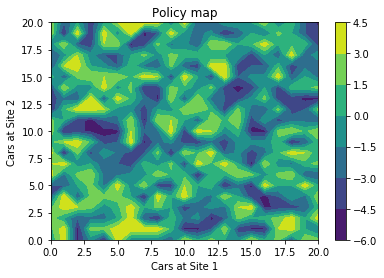

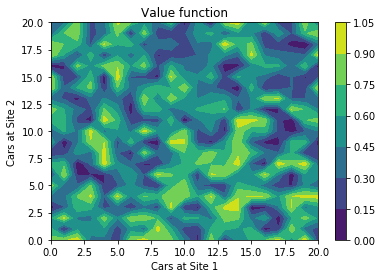

Evaluation steps: 23
Stable: False
Total value: 461467.82
Evaluation steps: 12
Stable: False
Total value: 506064.79
Evaluation steps: 2
Stable: False
Total value: 507739.69
Evaluation steps: 1
Stable: False
Total value: 508342.21
Evaluation steps: 1
Stable: False
Total value: 508834.47
Evaluation steps: 1
Stable: True
Total value: 509238.23


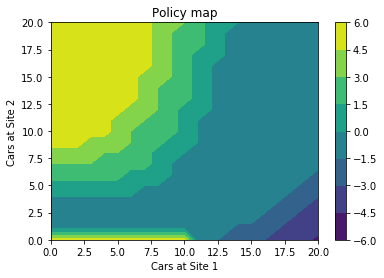

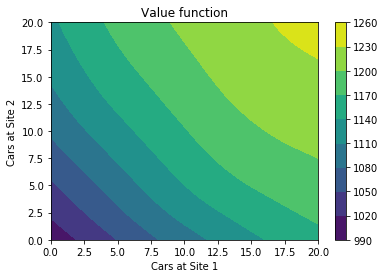

In [6]:
# Original problem

C=CarMarket(r1=10,r2=3,rt1=10)
M=MarketBot(C,exact=True,gamma=0.9)
M.viz_policy()
M.viz_value()
M.policy_iterate()
M.viz_policy()
M.viz_value()

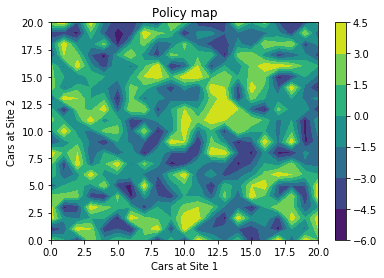

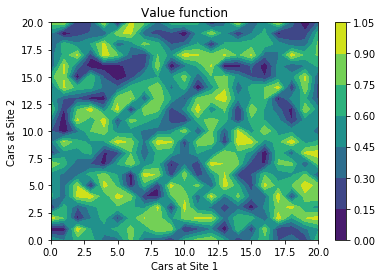

Evaluation steps: 22
Stable: False
Total value: 355079.51
Evaluation steps: 15
Stable: False
Total value: 451557.07
Evaluation steps: 3
Stable: False
Total value: 454396.3
Evaluation steps: 1
Stable: True
Total value: 455044.75


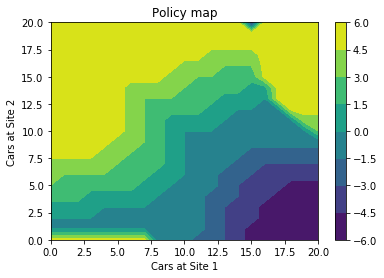

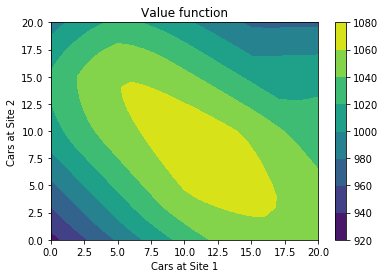

In [7]:
# Modified problem (free shipping + parking costs)

C=CarMarket(r1=10,r2=3,rt1=10,modified=True)
M=MarketBot(C,exact=True,gamma=0.9)
M.viz_policy()
M.viz_value()
M.policy_iterate()
M.viz_policy()
M.viz_value()